In [106]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [90]:
columns = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
    ]

df = pd.read_csv("bank-full.csv", delimiter=";")
df_use = df[columns]
X = df_use.drop(columns=["y"])
y = df_use["y"].map({'yes': 1, 'no': 0})

In [91]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.25, random_state=1)

## Question 1: ROC AUC feature importance

In [92]:
numeric = X_train.select_dtypes(include='number').columns
for col in numeric:
    auc = roc_auc_score(y_train, X_train[col])
    if  auc < 0.5:
        auc = roc_auc_score(y_train, -X_train[col])
    
    print(col+": ", round(auc, 4))

age:  0.5122
balance:  0.5888
day:  0.526
duration:  0.8147
campaign:  0.5715
pdays:  0.5901
previous:  0.5986


- Which numerical variable (among the following 4) has the highest AUC? **duration**

## Question 2: Training the model

In [93]:
dv = DictVectorizer(sparse=False)
new_X_train = dv.fit_transform(X_train.to_dict(orient="records"))
new_X_test = dv.transform(X_test.to_dict(orient="records"))
new_X_val = dv.transform(X_val.to_dict(orient="records"))

In [94]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [95]:
lr.fit(new_X_train, y_train)
y_pred = lr.predict_proba(new_X_val)[:,1]

In [96]:
round(roc_auc_score(y_val, y_pred),3)

0.9

- What's the AUC of this model on the validation dataset? (round to 3 digits) **0.9**

## Question 3: Precision and Recall

/home/unjoku/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


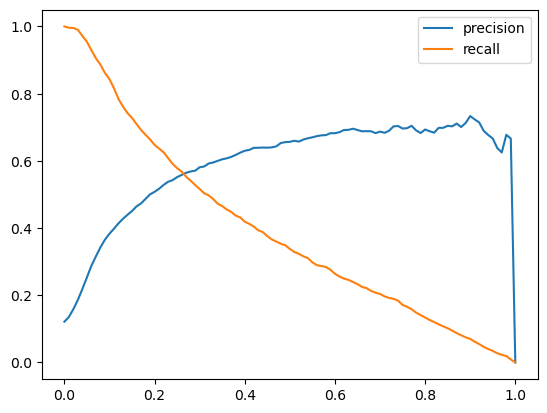

In [99]:
precision = []
recall = []
ths = np.arange(0.0, 1.01, 0.01)
for th in ths:
    y_pred_val = lr.predict_proba(new_X_val)[:,1]
    y_pred_val = (y_pred_val>=th).astype(int)
    precision.append(precision_score(y_val, y_pred_val))
    recall.append(recall_score(y_val, y_pred_val))
    
plt.plot(ths, precision, label='precision')
plt.plot(ths, recall, label='recall')

plt.legend()
plt.show()

- At which threshold precision and recall curves intersect? **0.265**

## Question 4: F1 score

/home/unjoku/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_933692/2695453059.py:8: RuntimeWarning: invalid value encountered in scalar divide
  f1 = 2*((precision*recall)/(precision+recall))


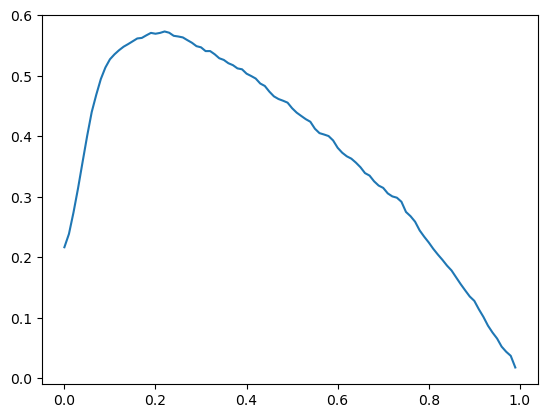

In [101]:
f1_scores = []
ths = np.arange(0.0, 1.01, 0.01)
for th in ths:
    y_pred_val = lr.predict_proba(new_X_val)[:,1]
    y_pred_val = (y_pred_val>=th).astype(int)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = 2*((precision*recall)/(precision+recall))
    f1_scores.append(f1)
    
plt.plot(ths, f1_scores)
plt.show()

- At which threshold F1 is maximal? **0.22**

In [103]:
X_.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
22468,52,management,married,tertiary,0,no,cellular,22,aug,232,2,-1,0,unknown
6896,50,admin.,single,secondary,330,yes,unknown,28,may,24,1,-1,0,unknown
28408,45,blue-collar,married,primary,300,yes,cellular,29,jan,203,1,261,3,failure
8481,38,technician,married,secondary,27,yes,unknown,3,jun,404,4,-1,0,unknown
28753,31,services,single,secondary,887,no,cellular,30,jan,427,1,-1,0,unknown


## Question 5: 5-Fold CV

In [112]:
full_train = dv.transform(X_.to_dict(orient="records"))

kf = KFold(n_splits=5, shuffle=True, random_state=1)


aucs = []
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
for train_idx, val_idx in tqdm(kf.split(full_train)):
    x_train = full_train[train_idx]
    x_val = full_train[val_idx]
    
    
    y_train = y_.iloc[train_idx]
    y_val = y_.iloc[val_idx]
                       
    
    lr.fit(x_train, y_train)
    y_pred_val = lr.predict_proba(x_val)[:,1]
    aucs.append(roc_auc_score(y_val, y_pred_val))


5it [00:01,  4.94it/s]


In [113]:
round(np.std(aucs), 3)

0.006

- How large is standard deviation of the scores across different folds? **0.006**

## Question 6: Hyperparameter Tuning

In [116]:
for c in tqdm([0.000001, 0.001, 1]):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    aucs = []
    lr = LogisticRegression(solver='liblinear', C=c, max_iter=1000)
    for train_idx, val_idx in kf.split(full_train):
        x_train = full_train[train_idx]
        x_val = full_train[val_idx]


        y_train = y_.iloc[train_idx]
        y_val = y_.iloc[val_idx]                 

        lr.fit(x_train, y_train)
        y_pred_val = lr.predict_proba(x_val)[:,1]
        aucs.append(roc_auc_score(y_val, y_pred_val))
    print(c,": ", round(np.mean(aucs), 3), "+", round(np.std(aucs), 4))

 33%|███████████████                              | 1/3 [00:00<00:00,  2.88it/s]

1e-06 :  0.701 + 0.0094


 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.79it/s]

0.001 :  0.861 + 0.0069


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.39it/s]

1 :  0.906 + 0.0055


- Which C leads to the best mean score? **1**